In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')

# ML + Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
import seaborn as sns

# !pip install category_encoders

import os
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./XGBoost+SHAP Test 1_NoCat.ipynb
./transaction_dataset_V8_Cleaned.csv
./transaction_dataset_V8.csv
./transaction_dataset.csv
./transaction_dataset_V3.csv
./transaction_dataset_V11.csv
./ethereum-anomaly-detection-XGBoost-NoCat.ipynb
./transaction_dataset_V8_Cleaned_Undersampling.csv
./Test6-NewDatasetNonTest-Copy1.ipynb
./transaction_dataset_V1_Undersampling_BALANCED.csv
./Test6-NewDatasetNonTest.ipynb
./fraud_model_Backup.pkl
./transaction_dataset_V1_SMOTEENN_BALANCED.csv
./transaction_dataset_V1_SMOTE_BALANCED.csv
./transaction_dataset_V10.csv
./Test6-Old.ipynb
./fraud_model.pkl
./Test7.ipynb
./transaction_dataset_V9.csv
./transaction_dataset_V4.csv
./Test6-NewDataset.ipynb
./transaction_dataset_V5.csv
./trees.txt
./transaction_dataset_V1.csv
./transaction_dataset_V8_Cleaned_Smoteen.csv
./TransactionDatasetV7Cleaned.csv
./transaction_dataset_V6.csv
./Test6-Backup.ipynb
./transaction_dataset_V8_Cleaned_Smote.csv
./transaction_dataset_V2.csv
./Test5.ipynb
./.ipynb_checkpoints/transact

In [2]:
# ============================
# 1. DATA LOADING & CLEANING
# ============================
print("\n1. Loading and cleaning data...")

# Load data
df = pd.read_csv("transaction_dataset_V11.csv")

# Clean column names
df.columns = df.columns.str.strip().str.replace(r'\s+', '_', regex=True)
df.columns = [col.strip().replace(' ', '_') for col in df.columns]

print(f"Original shape: {df.shape}")
print(f"Original columns: {len(df.columns)}")

# Remove ONLY the 2 problematic categorical columns + metadata
columns_to_drop = [
    'Unnamed:_0', 'Index', 'Address',           # Metadata
    'ERC20_most_sent_token_type',              # Categorical 1
    'ERC20_most_rec_token_type'                # Categorical 2
]

# Remove only if they exist
columns_to_drop = [col for col in columns_to_drop if col in df.columns]
print(f"Dropping {len(columns_to_drop)} columns: {columns_to_drop}")

df_clean = df.drop(columns=columns_to_drop, errors='ignore')

# Handle ALL NaN values with 0 (no ERC20 activity = 0)
df_clean = df_clean.fillna(0)

# Handle infinite values with 0
df_clean.replace([np.inf, -np.inf], 0, inplace=True)

# NEW: Clip extremely large values to prevent overflow
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
df_clean[numeric_cols] = df_clean[numeric_cols].clip(lower=-1e18, upper=1e18)

# Verify no infinite or excessively large values
if np.isinf(df_clean[numeric_cols].values).any():
    print("WARNING: Infinite values still present!")
elif (df_clean[numeric_cols].abs() > 1e18).any().any():
    print("WARNING: Excessively large values still present!")
else:
    print("✓ No infinite or excessively large values in data.")

print(f"Cleaned shape: {df_clean.shape}")
print(f"Columns kept: {len(df_clean.columns)}")


1. Loading and cleaning data...
Original shape: (10100, 52)
Original columns: 52
Dropping 5 columns: ['Unnamed:_0', 'Index', 'Address', 'ERC20_most_sent_token_type', 'ERC20_most_rec_token_type']
✓ No infinite or excessively large values in data.
Cleaned shape: (10100, 47)
Columns kept: 47


In [3]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10100 entries, 0 to 10099
Data columns (total 47 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Contract                                              10100 non-null  int64  
 1   FLAG                                                  10100 non-null  int64  
 2   Avg_min_between_sent_tnx                              10100 non-null  float64
 3   Avg_min_between_received_tnx                          10100 non-null  float64
 4   Time_Diff_between_first_and_last_(Mins)               10100 non-null  float64
 5   Sent_tnx                                              10100 non-null  int64  
 6   Received_Tnx                                          10100 non-null  int64  
 7   Number_of_Created_Contracts                           10100 non-null  int64  
 8   Unique_Received_From_Addresses                        10

In [4]:
# ============================
# 2. BASIC DATA CHECK
# ============================
print("\n2. Data verification...")

# Check target distribution
print(f"\nFLAG distribution:")
print(df_clean['FLAG'].value_counts(normalize=True))

# Check contract distribution
print(f"\nContract distribution:")
print(df_clean['Contract'].value_counts(normalize=True))

# Check for any remaining non-numeric columns
non_numeric = df_clean.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    print(f"\nWARNING: Non-numeric columns found: {non_numeric}")
else:
    print("\n✓ All columns are numeric!")


2. Data verification...

FLAG distribution:
FLAG
0    0.767822
1    0.232178
Name: proportion, dtype: float64

Contract distribution:
Contract
0    0.843168
1    0.156832
Name: proportion, dtype: float64

✓ All columns are numeric!


In [5]:
# ============================
# 3. PREPARE FEATURES AND TARGET
# ============================
print("\n3. Preparing features...")

# Separate features and target
X = df_clean.drop(['FLAG'], axis=1)
y = df_clean['FLAG']

# Force all features to float64
X = X.astype(float)
y = y.astype(int)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X dtype: {X.dtypes.unique()}")
print(f"y dtype: {y.dtype}")


3. Preparing features...
X shape: (10100, 46)
y shape: (10100,)
X dtype: [dtype('float64')]
y dtype: int64


In [6]:
# ============================
# 5. MODEL TRAINING
# ============================
print("\n5. Training XGBoost...")

# Handle class imbalance
neg, pos = y.value_counts()

scale_pos_weight = neg / pos
print(f"Class imbalance - Negatives: {neg}, Positives: {pos}")
print(f"Scale pos weight: {scale_pos_weight:.2f}")

# Initialize model with explicit missing value handling
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    missing=0,  # Explicitly set missing value to 0
    tree_method='hist',  # Use histogram-based method for stability
    device='cpu'  # Ensure CPU usage for reproducibility
)

# Train
print("Training model...")
model.fit(X, y)

print("✓ Model trained successfully!")
print(f"Model classes: {model.classes_}")

# # ============================
# # EXPORT TRAINED MODEL
# # ============================
import pickle
print("\nExporting model...")
with open('fraud_model.pkl', 'wb') as f:
    pickle.dump(model, f)
print("✓ Model successfully exported to fraud_model.pkl")


5. Training XGBoost...
Class imbalance - Negatives: 7755, Positives: 2345
Scale pos weight: 3.31
Training model...
✓ Model trained successfully!
Model classes: [0 1]

Exporting model...
✓ Model successfully exported to fraud_model.pkl



8. Feature importance...


Text(0.5, 1.0, 'Top 20 Feature Importances')

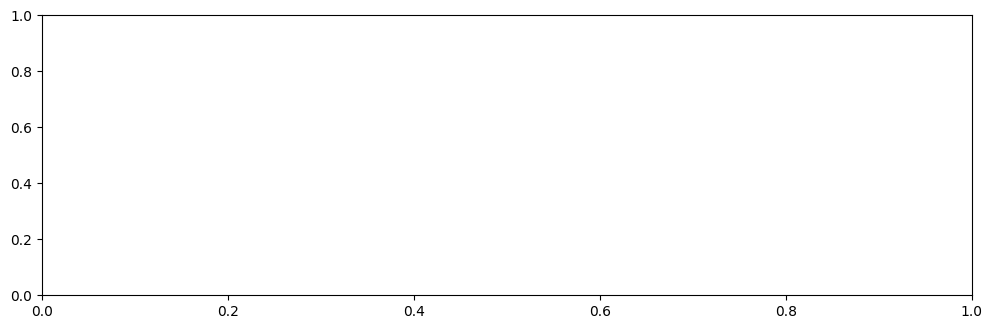

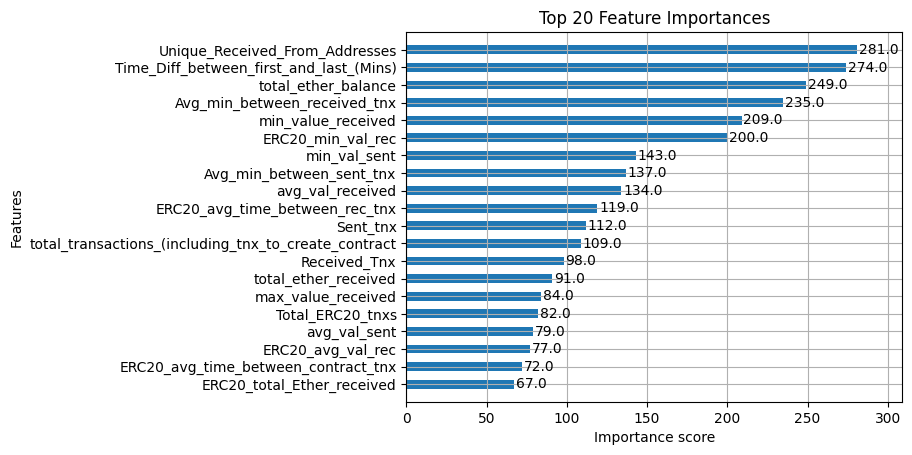

In [7]:
# ============================
# 8. FEATURE IMPORTANCE
# ============================
print("\n8. Feature importance...")

plt.figure(figsize=(12, 8))

# Plot feature importance
plt.subplot(2, 1, 1)
from xgboost import plot_importance
plot_importance(model, max_num_features=20, importance_type="weight", height=0.5)
plt.title('Top 20 Feature Importances')

# # Top features table
# plt.subplot(2, 1, 2)
# importance_df = pd.DataFrame({
#     'feature': X.columns,
#     'importance': model.feature_importances_
# }).sort_values('importance', ascending=True).head(15)

# # Create horizontal bar chart
# plt.barh(range(len(importance_df)), importance_df['importance'])
# plt.yticks(range(len(importance_df)), importance_df['feature'])
# plt.xlabel('Importance')
# plt.title('Top 15 Most Important Features')
# plt.gca().invert_yaxis()

# plt.tight_layout()
# plt.show()

# # Print top features
# print("\n=== TOP 15 FEATURES ===")
# print(importance_df[['feature', 'importance']].round(4))

# # ERC20 vs Native breakdown
# erc20_importance = importance_df[importance_df['feature'].str.startswith('ERC20')]['importance'].sum()
# native_importance = importance_df[~importance_df['feature'].str.startswith('ERC20')]['importance'].sum()
# total_importance = erc20_importance + native_importance

# print(f"\n=== FEATURE TYPE BREAKDOWN ===")
# print(f"ERC20 features contribution: {erc20_importance:.4f} ({erc20_importance/total_importance*100:.1f}%)")
# print(f"Native features contribution: {native_importance:.4f} ({native_importance/total_importance*100:.1f}%)")


8. Feature importance...
ERC20 features contribution: 25.9%
Native features contribution: 74.1%


<Figure size 1200x1000 with 0 Axes>

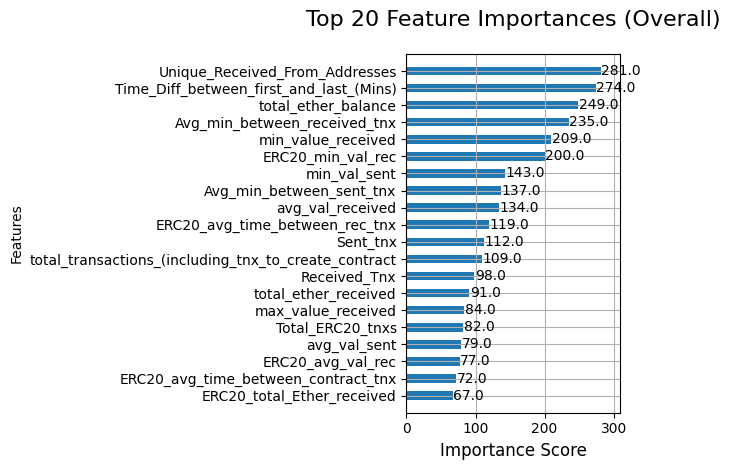

✓ Saved: feature_importance_overall.png


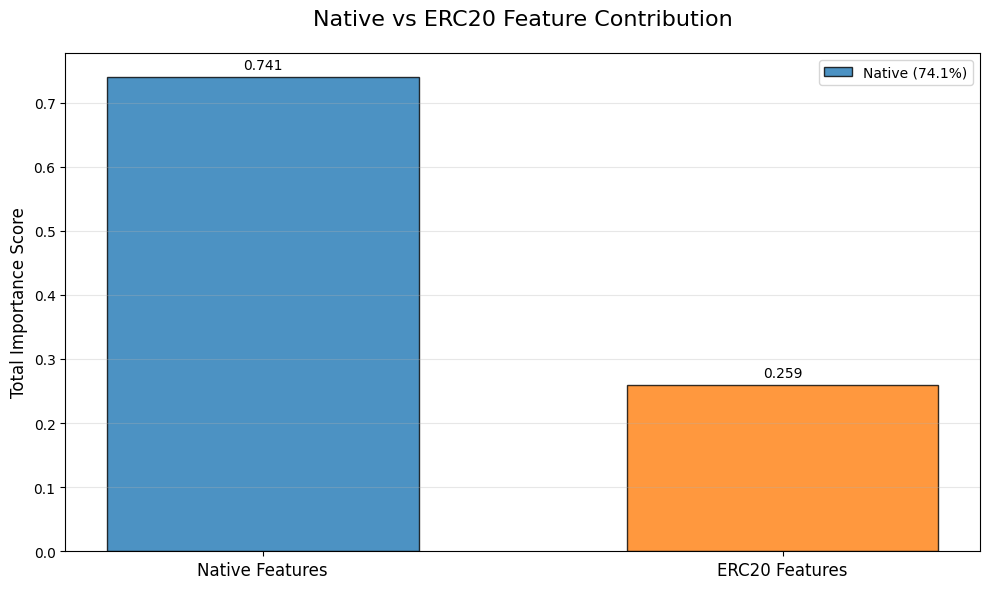

✓ Saved: feature_contribution_native_vs_erc20.png


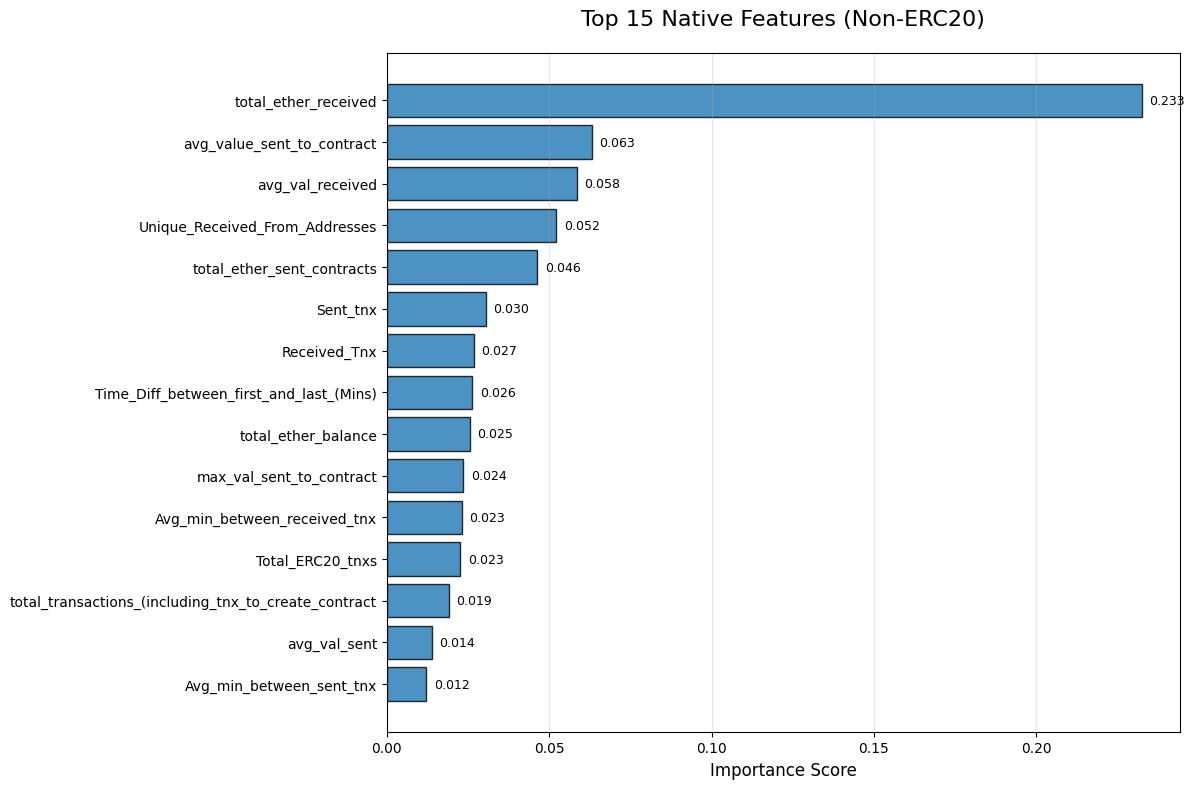

✓ Saved: top_native_features.png


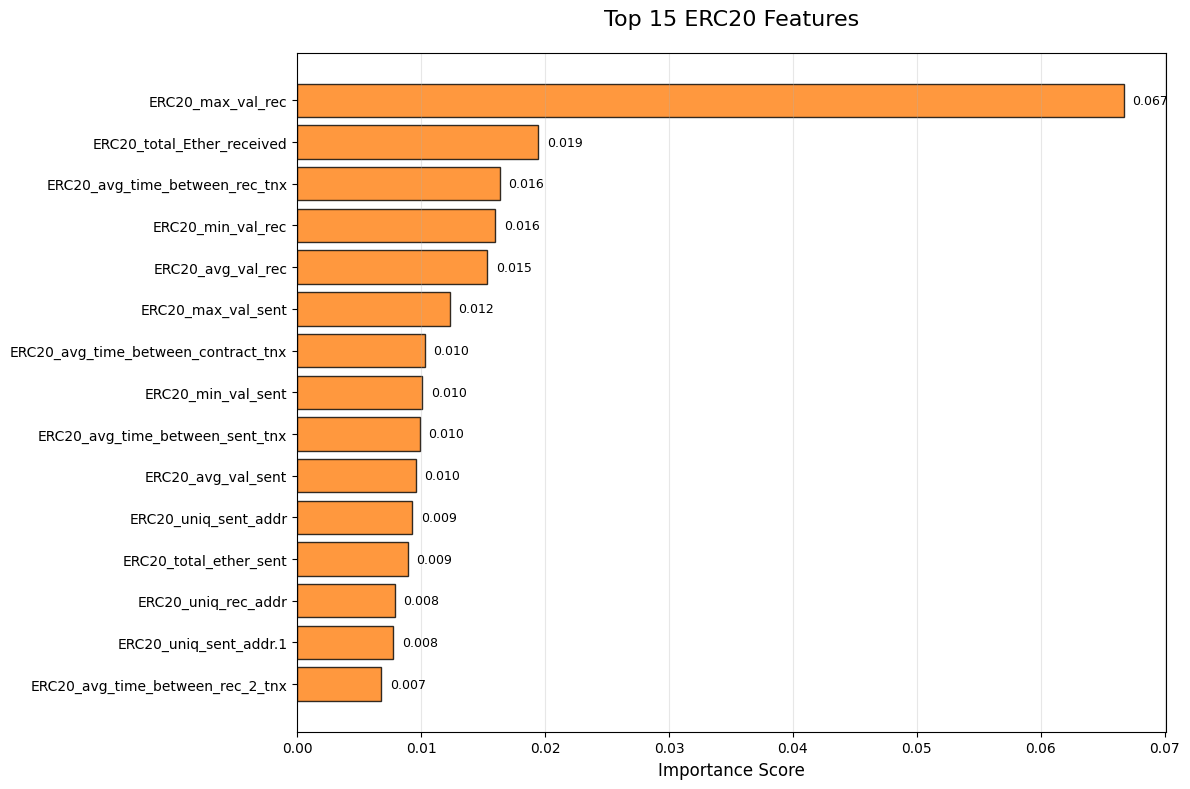

✓ Saved: top_erc20_features.png

=== TOP 10 OVERALL FEATURES ===
                                feature  importance
                   total_ether_received      0.2326
                      ERC20_max_val_rec      0.0667
             avg_value_sent_to_contract      0.0631
                       avg_val_received      0.0585
         Unique_Received_From_Addresses      0.0522
             total_ether_sent_contracts      0.0463
                               Sent_tnx      0.0304
                           Received_Tnx      0.0268
Time_Diff_between_first_and_last_(Mins)      0.0263
                    total_ether_balance      0.0255

=== SUMMARY ===
Generated 4 clean PNG files:
  📊 feature_importance_overall.png
  📈 feature_contribution_native_vs_erc20.png
  🔵 top_native_features.png
  🟠 top_erc20_features.png


In [8]:
# ============================
# 8. FEATURE IMPORTANCE
# ============================
print("\n8. Feature importance...")

# Get feature importance data
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Separate native and ERC20 features for analysis
native_features = importance_df[~importance_df['feature'].str.startswith('ERC20')].head(15)
erc20_features = importance_df[importance_df['feature'].str.startswith('ERC20')].head(15)

# ERC20 vs Native breakdown
erc20_importance = importance_df[importance_df['feature'].str.startswith('ERC20')]['importance'].sum()
native_importance = importance_df[~importance_df['feature'].str.startswith('ERC20')]['importance'].sum()
total_importance = erc20_importance + native_importance
erc20_contribution = erc20_importance / total_importance * 100

print(f"ERC20 features contribution: {erc20_contribution:.1f}%")
print(f"Native features contribution: {100 - erc20_contribution:.1f}%")

# PLOT 1: Overall Top 20 Features (XGBoost native plot)
plt.figure(figsize=(12, 10))
from xgboost import plot_importance
plot_importance(model, max_num_features=20, importance_type="weight", height=0.5, title="")
plt.title('Top 20 Feature Importances (Overall)', fontsize=16, pad=20)
plt.xlabel('Importance Score', fontsize=12)
plt.tight_layout()
#plt.savefig('feature_importance_overall.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: feature_importance_overall.png")

# PLOT 2: Native vs ERC20 Contribution (Bar Chart)
plt.figure(figsize=(10, 6))
x_pos = [0, 1]
plt.bar(x_pos, [native_importance, erc20_importance], 
        width=0.6, color=['#1f77b4', '#ff7f0e'], alpha=0.8, edgecolor='black')
plt.xticks(x_pos, ['Native Features', 'ERC20 Features'], fontsize=12)
plt.ylabel('Total Importance Score', fontsize=12)
plt.title('Native vs ERC20 Feature Contribution', fontsize=16, pad=20)
plt.legend(['Native (%.1f%%)' % (100 - erc20_contribution), 
           'ERC20 (%.1f%%)' % erc20_contribution], fontsize=10)

# Add value labels on bars
for i, v in enumerate([native_importance, erc20_importance]):
    plt.text(i, v + max([native_importance, erc20_importance]) * 0.01, 
             f'{v:.3f}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
#plt.savefig('feature_contribution_native_vs_erc20.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: feature_contribution_native_vs_erc20.png")

# PLOT 3: Top 15 Native Features (Horizontal Bar Chart)
plt.figure(figsize=(12, 8))
if len(native_features) > 0:
    plt.barh(range(len(native_features)), native_features['importance'], 
             color='#1f77b4', alpha=0.8, edgecolor='black')
    plt.yticks(range(len(native_features)), native_features['feature'], fontsize=10)
    plt.xlabel('Importance Score', fontsize=12)
    plt.title('Top 15 Native Features (Non-ERC20)', fontsize=16, pad=20)
    plt.gca().invert_yaxis()
    
    # Add value labels
    for i, v in enumerate(native_features['importance']):
        plt.text(v + max(native_features['importance']) * 0.01, i, f'{v:.3f}', 
                va='center', fontsize=9)
    
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    #plt.savefig('top_native_features.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: top_native_features.png")
else:
    print("No native features found")

# PLOT 4: Top 15 ERC20 Features (Horizontal Bar Chart) - BONUS
plt.figure(figsize=(12, 8))
if len(erc20_features) > 0:
    plt.barh(range(len(erc20_features)), erc20_features['importance'], 
             color='#ff7f0e', alpha=0.8, edgecolor='black')
    plt.yticks(range(len(erc20_features)), erc20_features['feature'], fontsize=10)
    plt.xlabel('Importance Score', fontsize=12)
    plt.title('Top 15 ERC20 Features', fontsize=16, pad=20)
    plt.gca().invert_yaxis()
    
    # Add value labels
    for i, v in enumerate(erc20_features['importance']):
        plt.text(v + max(erc20_features['importance']) * 0.01, i, f'{v:.3f}', 
                va='center', fontsize=9)
    
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    #plt.savefig('top_erc20_features.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: top_erc20_features.png")
else:
    print("No ERC20 features found")

# Print top features summary
print("\n=== TOP 10 OVERALL FEATURES ===")
print(importance_df.head(10)[['feature', 'importance']].round(4).to_string(index=False))

print(f"\n=== SUMMARY ===")
print(f"Generated 4 clean PNG files:")
print(f"  📊 feature_importance_overall.png")
print(f"  📈 feature_contribution_native_vs_erc20.png") 
print(f"  🔵 top_native_features.png")
print(f"  🟠 top_erc20_features.png")

In [9]:
pip install dtreeviz

Note: you may need to restart the kernel to use updated packages.


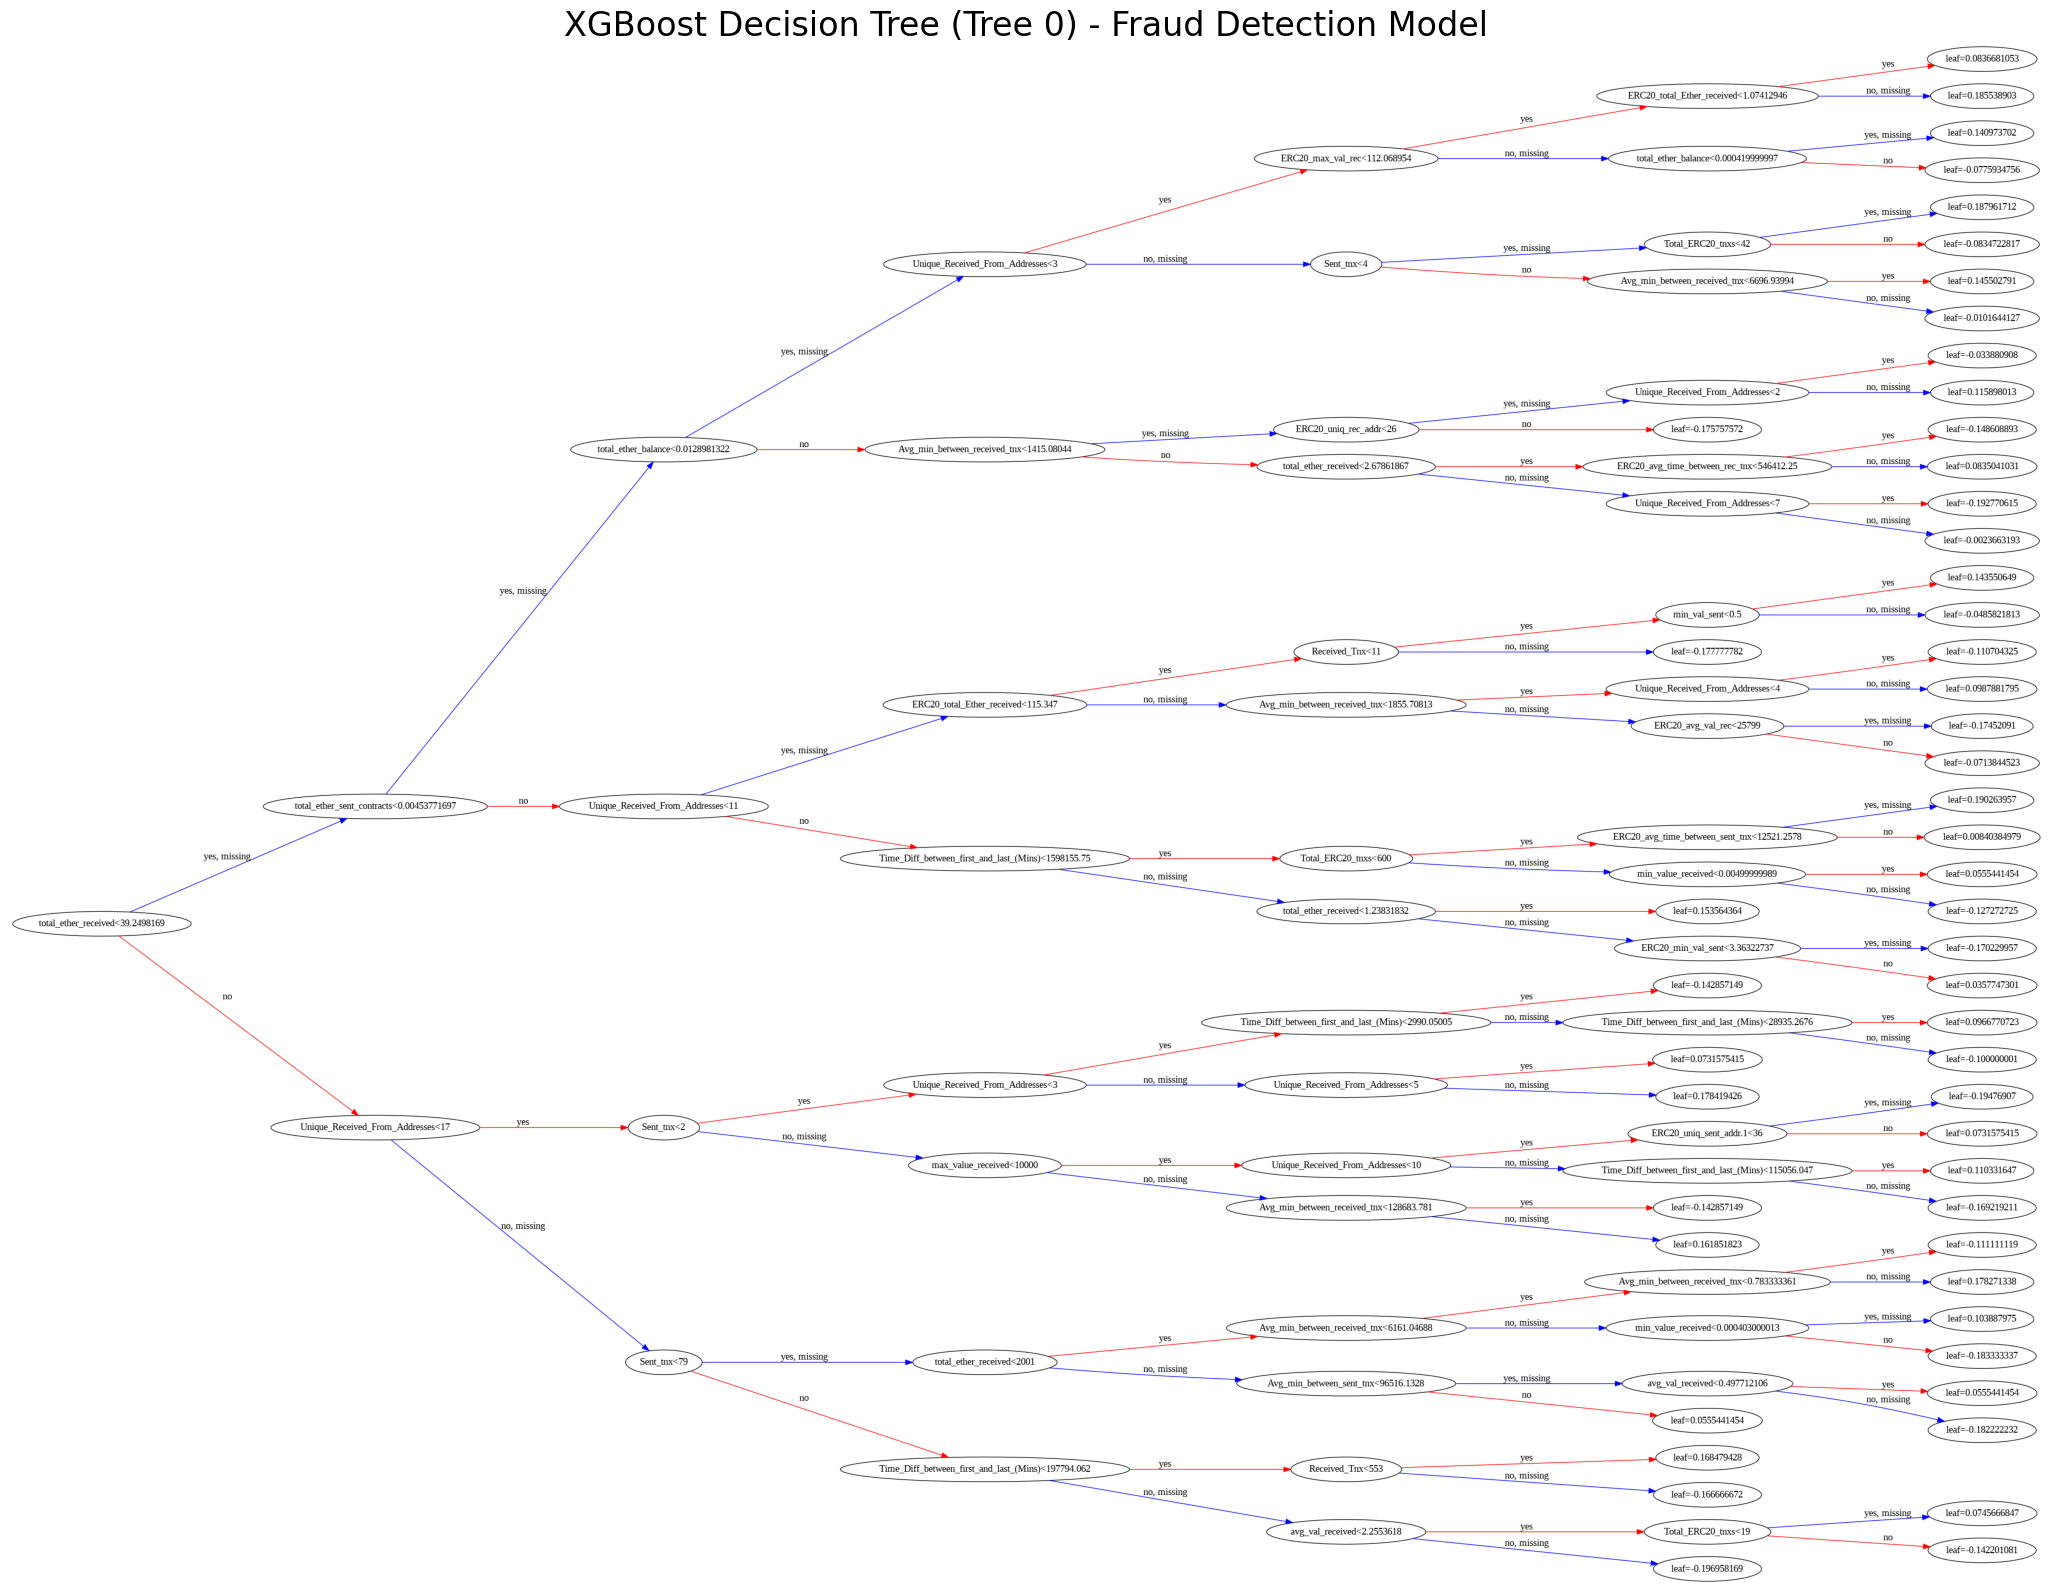

Tree visualization saved as 'xgboost_tree_0.png' (600 DPI, large size)


In [11]:
import pickle
import xgboost as xgb
import matplotlib.pyplot as plt

# Load your pickled XGBoost model
# Replace 'fraud_model.pkl' with the exact path if needed
model = pickle.load(open('fraud_model.pkl', 'rb'))

# Visualize the first decision tree (num_trees=0) - adjust num_trees if you want another one
# figsize=(30, 20) makes it large; rankdir='LR' for horizontal layout (easier to read wide trees)
# You can change to 'TB' (top-to-bottom) if preferred
fig, ax = plt.subplots(figsize=(30, 20))
xgb.plot_tree(model, num_trees=0, ax=ax, rankdir='LR')

# Optional: Add a title
plt.title('XGBoost Decision Tree (Tree 0) - Fraud Detection Model', fontsize=24)

# Save the image with high resolution
plt.savefig('xgboost_tree_0.png', dpi=600, bbox_inches='tight')

# Optional: Display in notebook
plt.show()

# Close the figure to free memory (good practice in notebooks)
plt.close(fig)

print("Tree visualization saved as 'xgboost_tree_0.png' (600 DPI, large size)")